# Evaluate a bird song network

In [1]:
%config InlineBackend.figure_format = 'jpg'  # smaller mem footprint for page

import zarr
import librosa.feature, librosa.display
import numpy as np
import matplotlib.pyplot as plt
import colorcet as cc
import sklearn.metrics
import scipy.stats
from matplotlib.colors import ListedColormap

import das.utils, das.utils_plot, das.predict, das.data, das.models, das.train, das.io, das.evaluate, das.segment_utils

plt.style.use('ncb.mplstyle')

## Load data

In [2]:
savename = '../../../../dss.paper/sober/20200418_215107'
params = das.utils.load_params(savename)
store = zarr.open(savename + '.zarr')

fs = 32_000  # Hz
# sequence of ints - "0" if no song, >0 if syllable 
# labels_pred = store['labels_pred'][:fs * 500]


In [3]:
save_name = '../../../../dss.paper/models/sober_allInd/20200418_215107'

gap_dur = 5 / 1000  # 5 ms
min_len = 30 / 1000  # 30 ms

# x_test = store['x_test'][:]
# events, segments, y_pred = das.predict.predict(x_test[:fs * 500], model_save_name=save_name, verbose=1, segment_minlen=min_len, segment_fillgap=gap_dur)
# np.save('confidence_scores.npy', y_pred)

y_pred = np.load('confidence_scores.npy')#[:1_000_000]

labels_test = store['labels_test'][:y_pred.shape[0]]

## Predict syllable labels
Based on majority vote

In [4]:
# get true syllable labels from predictions
_, segments_pred = das.predict.predict_song(y_pred, params, 
                                            segment_minlen=min_len,
                                            segment_fillgap=gap_dur)

# get true syllable labels from training targets
_, segments_test = das.predict.predict_song(labels_test, params,
                                            segment_minlen=min_len,
                                            segment_fillgap=gap_dur)

# re-run, using the on- and offsets of predicted syllables as a reference for determining the "true" labels
_, segments_test_pred = das.predict.predict_song(labels_test, params,
                                            segment_ref_onsets=segments_pred['onsets_seconds'],
                                            segment_ref_offsets=segments_pred['offsets_seconds'],
                                            segment_minlen=min_len,
                                            segment_fillgap=gap_dur)

In [5]:
labels_pred = segments_pred['samples']
labels_test = segments_test['samples']
min_len = min(len(labels_test), len(labels_pred))

labels_pred = labels_pred[:min_len]
labels_test = labels_test[:min_len]

syllable_true_pred = segments_test_pred['sequence']
syllable_pred_pred = segments_pred['sequence']

## Inspect data and predictions

/Users/clemens10/miniconda3/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/clemens10/miniconda3/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


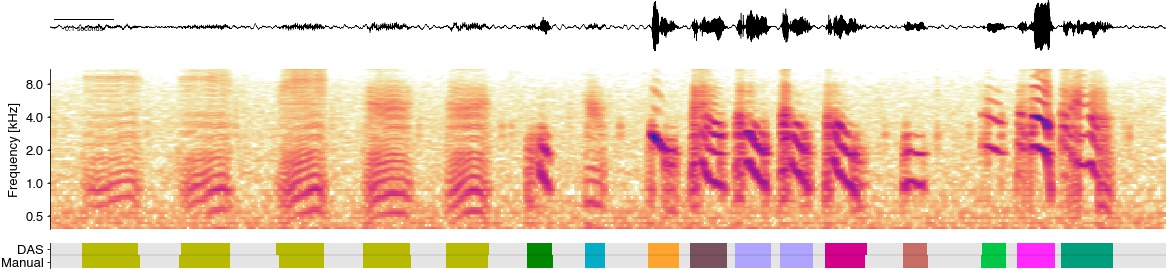

In [6]:
t0 = 532_000 
t1 = t0 + 60_000

x = store['x_test'][t0:t1,0]

T = np.arange(len(x))/fs
hop_length = 100
specgram = librosa.feature.melspectrogram(x, sr=32_000, n_fft=512+256, hop_length=hop_length, power=1)
specgram = librosa.amplitude_to_db(specgram, np.max)
labels_all = np.stack((labels_pred[t0:t1].T, labels_test[t0:t1].T))
labels_all = np.unique(labels_all, return_inverse=True)[1].reshape((2, -1))

cmap = cc.palette['glasbey_light'][1::2]
cmap = list(cmap)[:12]
cmap.insert(0, (0.9, 0.9, 0.9))
cmap = ListedColormap(cmap)

plt.gcf().set_size_inches(20, 10)
plt.subplot(913)
plt.plot(T, x, c='k', linewidth=0.5)
plt.axis('tight')
das.utils_plot.scalebar(.1, units='seconds', location='center left',
                        font_properties={'size': 7})
das.utils_plot.remove_axes(all=True)


ax = plt.subplot(312)
im = librosa.display.specshow(specgram, 
                            sr=32_000, hop_length=hop_length, y_axis='mel', x_axis='s', 
                            cmap=ListedColormap(list((cc.CET_L17))))
freqs = 1000 * 2.0 ** np.arange(-1, 4)
plt.yticks(freqs, freqs/1000)
plt.ylim(300)
plt.ylabel('Frequency [kHz]')
plt.clim(-70, 0)
ax.spines['bottom'].set_visible(False)
plt.xticks(())
plt.xlabel(None)

ax = plt.subplot(18,1, 13)
plt.imshow(labels_all, cmap=cmap)
plt.axhline(0.5, c='k', alpha=0.1)
plt.yticks((0, 1), labels=['Manual', 'DAS']);
ax.spines['bottom'].set_visible(False)
plt.xticks(())
das.utils_plot.remove_axes()


## Performance metrics
### Sample-wise

In [7]:
cr = sklearn.metrics.classification_report(labels_test[::10], labels_pred[::10], 
                                           output_dict=False,
                                           labels=np.arange(1, 50))
print(cr)

/Users/clemens10/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/clemens10/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/clemens10/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/clemens10/minicon

              precision    recall  f1-score   support

           1       0.96      0.96      0.96      8218
           2       0.99      0.99      0.99     51073
           3       0.96      0.98      0.97     10210
           4       1.00      0.98      0.99      3193
           5       0.99      0.99      0.99     44374
           6       0.93      0.80      0.86      4208
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.98      0.98      0.98     29245
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.96      0.99      0.98      4086
          15       0.93      0.99      0.96      3850
          16       0.99      0.99      0.99      6240
          17       0.99      1.00      0.99      7110
          18       0.99    

/Users/clemens10/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/clemens10/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Syllable labels

/Users/clemens10/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log2


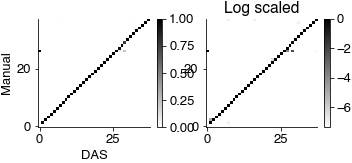

Micro avg 0.9632938342579566
Global avg 0.9915025106218617
(38, 38)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.97      0.98      0.98        63
           2       1.00      0.99      1.00       363
           3       1.00      1.00      1.00        47
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00       217
           6       1.00      1.00      1.00        28
           9       0.98      1.00      0.99       118
          14       1.00      1.00      1.00        35
          15       1.00      1.00      1.00        35
          16       1.00      1.00      1.00        35
          17       1.00      1.00      1.00        35
          18       1.00      1.00      1.00        70
          19       1.00      1.00      1.00        35
          20       1.00      1.00      1.00        34
          21       1.00      1.00      1.00        34
          22 

/Users/clemens10/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/clemens10/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/clemens10/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
conf_mat_pred = sklearn.metrics.confusion_matrix(syllable_true_pred[syllable_true_pred!=26],
                            syllable_pred_pred[syllable_true_pred!=26],
                            labels=np.arange(0, 50))
# remove syllables not in the test set
good_sylls = np.sum(conf_mat_pred, axis=0)>1
good_sylls[0] = True  # include 0 to depict false positives and false negatives
conf_mat_pred = conf_mat_pred[good_sylls,:]
conf_mat_pred = conf_mat_pred[:, good_sylls]

plt.gcf().set_size_inches(8.5, 2)
plt.subplot(131)
plt.imshow(conf_mat_pred / np.sum(conf_mat_pred, axis=0), cmap='gray_r')
plt.colorbar()
plt.ylabel('Manual')
plt.xlabel('DAS')

plt.subplot(132)
plt.imshow(np.log2(conf_mat_pred / np.sum(conf_mat_pred, axis=0)), cmap='gray_r')
plt.colorbar()
plt.title('Log scaled')
plt.show()

print('Micro avg', np.nanmean(np.diag(conf_mat_pred / np.nansum(conf_mat_pred, axis=0))))
print('Global avg', np.nansum(np.diag(conf_mat_pred)) / np.nansum(conf_mat_pred))
print(conf_mat_pred.shape)

# syllable "26" is mislabelled
syllable_true_pred[syllable_true_pred==26] = 0
syllable_pred_pred[syllable_true_pred==26] = 0

cr = sklearn.metrics.classification_report(syllable_true_pred[syllable_true_pred>0], 
                                           syllable_pred_pred[syllable_true_pred>0],
                                           output_dict=False)
print(cr)
print('FN rate (%) ', 100*np.mean(syllable_true_pred==0), 100*np.mean(syllable_pred_pred==0))

### Timing of syllable on- and offsets 

{'OFFSETS:'}
   FP 32, TP 2558, FN 26
   precision 0.99, recall 0.99, f1-score 0.99
   jitter: mean 0.74 ms, median 0.47 ms, 95th percentile 2.44 ms
   jitter full: mean 3.10 ms, median 0.47 ms, 95th percentile 2.77 ms
{'ONSETS:'}
   FP 32, TP 2558, FN 26
   precision 0.99, recall 0.99, f1-score 0.99
   jitter: mean 0.43 ms, median 0.22 ms, 95th percentile 1.41 ms
   jitter full: mean 2.86 ms, median 0.22 ms, 95th percentile 1.66 ms
jitter all full: mean 2.98 ms, median 0.31 ms, 95th percentile 2.44 ms


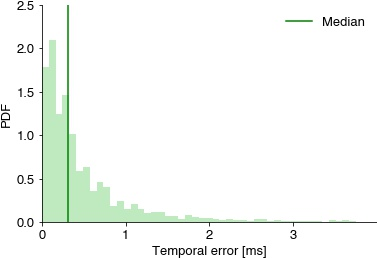

In [9]:
tol = 0.01  # seconds
nn_dist_all = np.zeros((0,))

for ii in range(2):
    if ii==1:
        times_test = segments_test['onsets_seconds']  # event_onsets_true
        times_pred = segments_pred['onsets_seconds']  # event_onsets_pred
        print({"ONSETS:"})
    else:
        times_test = segments_test['offsets_seconds']  # event_offsets_true
        times_pred = segments_pred['offsets_seconds']  # event_offsets_pred
        print({"OFFSETS:"})

    d, nn_pred_pulse, nn_true_pulse, nn_dist = das.event_utils.evaluate_eventtimes(times_test, times_pred, fs, tol)
    
    print(f"   FP {d['FP']}, TP {d['TP']}, FN {d['FN']}")
    print(f"   precision {d['precision']:1.2f}, recall {d['recall']:1.2f}, f1-score {d['f1_score']:1.2f}")
    print(f'   jitter: mean {np.mean(nn_dist[nn_dist<tol]) * 1000:1.2f} ms, median {np.median(nn_dist[nn_dist<tol]) * 1000 :1.2f} ms, 95th percentile {np.percentile(nn_dist[nn_dist<tol], 95) * 1000 :1.2f} ms')
    print(f'   jitter full: mean {np.mean(nn_dist) * 1000:1.2f} ms, median {np.median(nn_dist) * 1000 :1.2f} ms, 95th percentile {np.percentile(nn_dist, 95) * 1000 :1.2f} ms')
    
    nn_dist_all = np.concatenate((nn_dist_all, nn_dist))
print(f'jitter all full: mean {np.mean(nn_dist_all) * 1000:1.2f} ms, median {np.median(nn_dist_all) * 1000 :1.2f} ms, 95th percentile {np.percentile(nn_dist_all, 95) * 1000 :1.2f} ms')

plt.hist(nn_dist_all * 1000, bins=np.linspace(0, 4, 50), density=True, color=[0, .67, 0, 0.25])
plt.axvline(np.median(nn_dist_all * 1000), color='green', label='Median')
plt.xlabel('Temporal error [ms]')
plt.ylabel('PDF');
plt.xlim(0, 4)
plt.xticks(np.arange(0, 4))
plt.legend()
plt.show()